In [ ]:
%pip install feature-engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 kB 9.4 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve, auc, accuracy_score, mean_squared_error, roc_auc_score

from sklearn.linear_model import LogisticRegression

from feature_engine.creation import CyclicalFeatures

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/IS4303/notebooks/new_cleaned

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1bVEDexCX0JHyULN4EWuXWgee-vt0kzNA/IS4303/notebooks/new_cleaned


In [ ]:
df=pd.read_csv('2cleaned.csv')

In [ ]:
df.head()

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable
0,0,7,July,27,0,1,1,0.0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,0,13,July,27,0,1,1,0.0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,0,14,July,27,0,2,2,0.0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,0,0,July,27,0,2,2,0.0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,9,July,27,0,2,2,0.0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [ ]:
months = {"JANUARY" : 1,"FEBRUARY" : 2,"MARCH" : 3,"APRIL": 4, "MAY": 5, "JUNE": 6, "JULY": 7, "AUGUST": 8, "SEPTEMBER": 9, "OCTOBER": 10, "NOVEMBER": 11, "DECEMBER": 12}
df['arrival_date_month'] = df['arrival_date_month'].apply(lambda x: months[str(x).upper()])

In [ ]:
cyclical_features = CyclicalFeatures(["arrival_date_month", "arrival_date_week_number"], drop_original=True)
cyclical_features_df = cyclical_features.fit_transform(df)
cyclical_features_df.head()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,arrival_date_month_sin,arrival_date_month_cos,arrival_date_week_number_sin,arrival_date_week_number_cos
0,0,7,0,1,1,0.0,0,0,0,0,...,0,1,0,1,0,0,-0.5,-0.866025,-0.059241,-0.998244
1,0,13,0,1,1,0.0,0,0,0,0,...,0,1,0,1,0,0,-0.5,-0.866025,-0.059241,-0.998244
2,0,14,0,2,2,0.0,0,0,0,0,...,0,1,0,1,0,0,-0.5,-0.866025,-0.059241,-0.998244
3,0,0,0,2,2,0.0,0,0,0,0,...,0,1,0,1,0,0,-0.5,-0.866025,-0.059241,-0.998244
4,0,9,0,2,2,0.0,0,0,0,0,...,0,1,0,1,0,0,-0.5,-0.866025,-0.059241,-0.998244


In [ ]:
sin_only_df = cyclical_features_df.drop(["arrival_date_month_cos", "arrival_date_week_number_cos"], axis=1)
cos_only_df = cyclical_features_df.drop(["arrival_date_month_sin", "arrival_date_week_number_sin"], axis=1)

In [ ]:
import pickle

with open("FittedCyclicalEncoder.pkl", mode="wb") as f:
    pickle.dump(cyclical_features, f)

In [ ]:
logistic_regression = LogisticRegression(max_iter=500)

##Evaluation Functions

In [ ]:
def plot_roc(y_test_lst, y_pred_lst):
    plt.figure(figsize=(24,6))
    
    for i in range(len(y_test_lst)):
        fpr, tpr, _ = roc_curve(y_test_lst[i], y_pred_lst[i])
        plt.plot(fpr, tpr, label = 'Fold %d: ROC=%.4f' % (i+1, roc_auc_score(y_test_lst[i], y_pred_lst[i])))

    plt.title(f'Receiver Operating Characteristic (ROC) Curve')
    plt.plot([0, 1], ls="--")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()

In [ ]:
# Function to plot Precision Recall Curve for each Cross Validation Fold
def plot_precision_recall(y_test_lst, y_pred_lst):
    filter_arr = y == 1
    baseline = len(y[filter_arr]) / len(y)
    plt.figure(figsize=(24,6))

    for i in range(len(y_test_lst)):
        precision, recall, thresholds = precision_recall_curve(y_test_lst[i], y_pred_lst[i])
        plt.plot(recall, precision, label = 'Fold %d: AUC=%.4f' % (i+1, auc(recall, precision)))
    
    plt.plot([0, 1], [baseline, baseline], linestyle = '--')  #baseline
    plt.xlabel('Recall', fontsize = 14)
    plt.ylabel('Precision', fontsize = 14)
    plt.title('Precision-Recall Curve', fontsize = 22)
    plt.legend()
    plt.show()

In [ ]:
# Function to print the average classification report of all the reports
# from each cross-validation.
def print_classification_report(class_report_dict):
    class_report_np = []
    for report in class_report_dict:
        class_report_np.append(pd.DataFrame(report).to_numpy())
    res = pd.DataFrame(np.mean(class_report_np, axis=0))
    res = res.rename(columns={0: "0", 1: "1", 2: "accuracy", 3: "macro avg", 4: "weighted avg"})
    res = res.rename(index={0: "precision", 1: "recall", 2: "f1-score", 3: "support"})
    return res

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm) # Print the raw confusion matrix

    # Create plot
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##CrossFold Function

In [ ]:
def cross_val_base(mod, numFolds, X, y):
  conf_matrix_lst = []
  classification_report_lst = []
  y_test_lst = []
  y_predprob_lst = []

  kf = StratifiedKFold(n_splits=numFolds)
  for fold, (train_index, test_index) in enumerate(kf.split(X,y)):

      X_train = X[train_index]
      y_train = y[train_index]
      X_test = X[test_index]
      y_test = y[test_index] 


      stan_scaler = StandardScaler()
      X_train_stan = stan_scaler.fit_transform(X_train)
      X_test_stan = stan_scaler.transform(X_test)

      mod.fit(X_train_stan, y_train)

      y_pred = mod.predict(X_test_stan)

      conf_matrix = confusion_matrix(y_test, y_pred)
      conf_matrix_lst.append(conf_matrix)

      classification_report_lst.append(classification_report(y_test, y_pred, zero_division=0, output_dict=True))
      y_test_lst.append(y_test)
      
      y_predprob_lst.append(mod.predict_proba(X_test_stan)[:,1])
      
  return classification_report_lst, np.mean(conf_matrix_lst, axis=0), y_test_lst, y_predprob_lst

In [ ]:
def run_test(X, y):
    logistic_regression = LogisticRegression(max_iter=500)
    scores, conf_matrix, y_test_lst, y_predprob_lst  = cross_val_base(logistic_regression, 10, X, y)

    print(pd.DataFrame(conf_matrix))

    sns.set_style('white') 
    class_names = ['0','1']
    plot_confusion_matrix(conf_matrix,
                        classes=class_names, normalize=True,
                        title='Normalized Confusion Matrix: Logistic Regression')
    
    plot_precision_recall(y_test_lst, y_predprob_lst)
    print("\n")
    plot_roc(y_test_lst, y_predprob_lst)

    print(print_classification_report(scores))

#Runs

##Both sin and cos

        0      1
0  3860.0  596.9
1  1161.6  815.8
[[0.86607283 0.13392717]
 [0.58743805 0.41256195]]


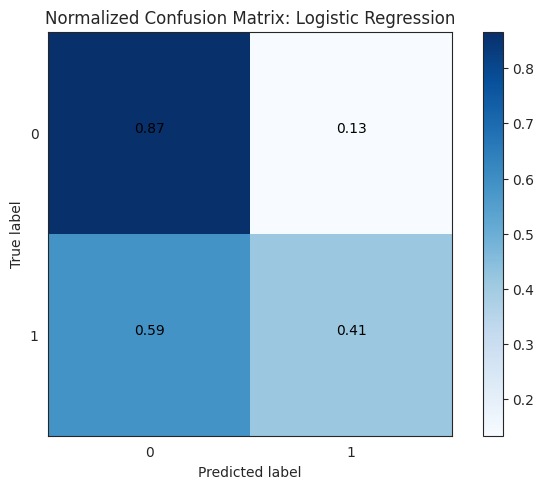

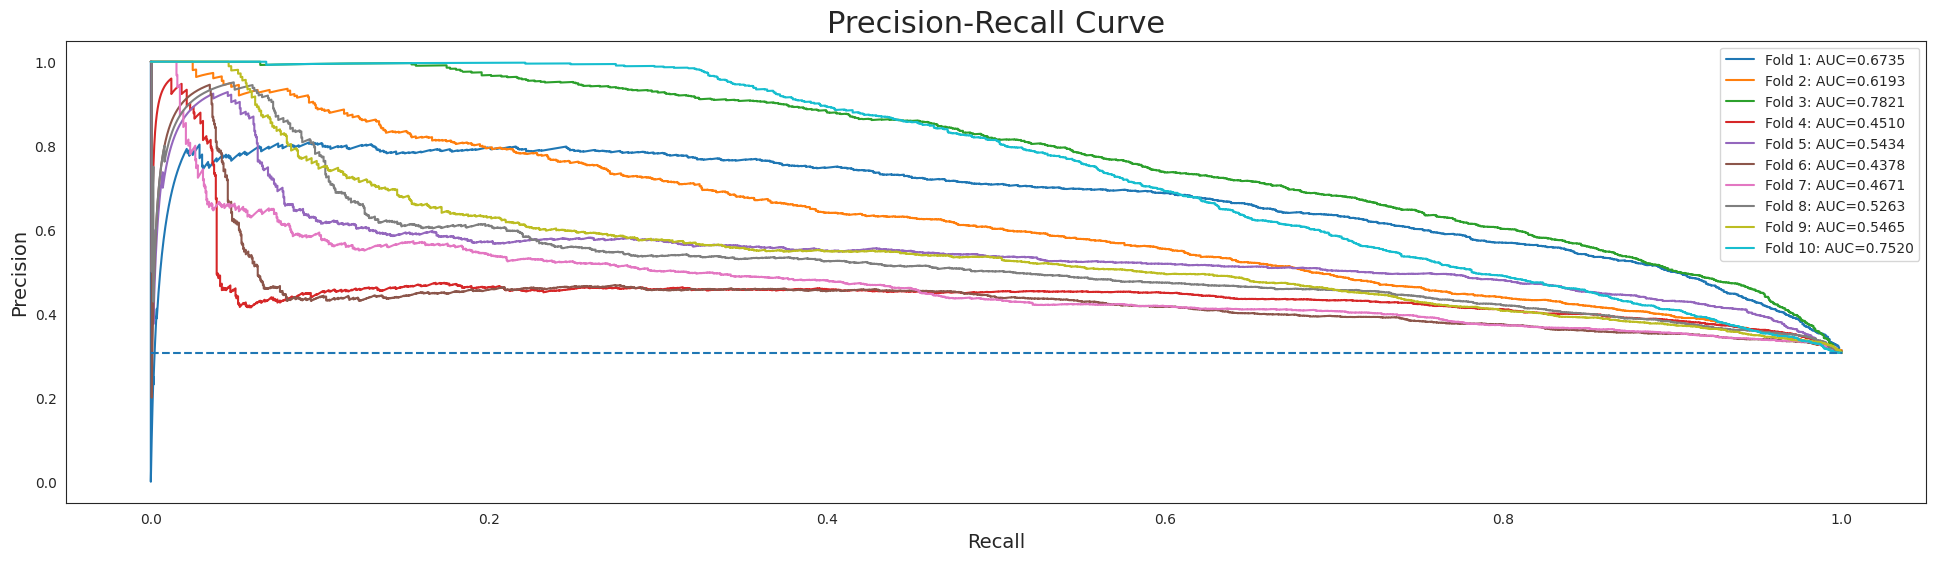

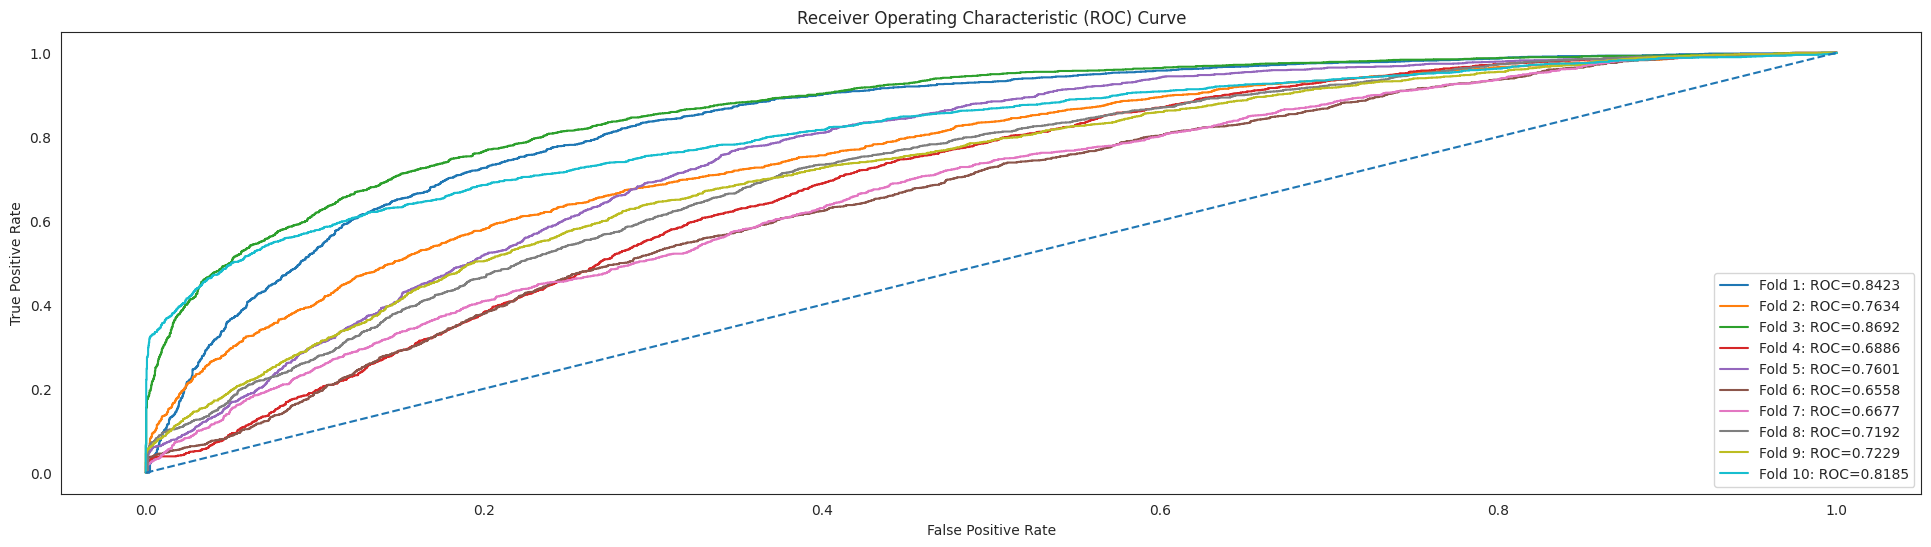

                     0            1  accuracy    macro avg  weighted avg
precision     0.771291     0.580814  0.726697     0.676053      0.712756
recall        0.866071     0.412541  0.726697     0.639306      0.726697
f1-score      0.814195     0.472422  0.726697     0.643309      0.709165
support    4456.900000  1977.400000  0.726697  6434.300000   6434.300000


In [ ]:
X = np.array(cyclical_features_df.drop("is_canceled", axis=1))
y = np.array(cyclical_features_df["is_canceled"])

run_test(X, y)

##Sin only

        0      1
0  3900.2  556.7
1  1138.9  838.5
[[0.87509255 0.12490745]
 [0.57595833 0.42404167]]


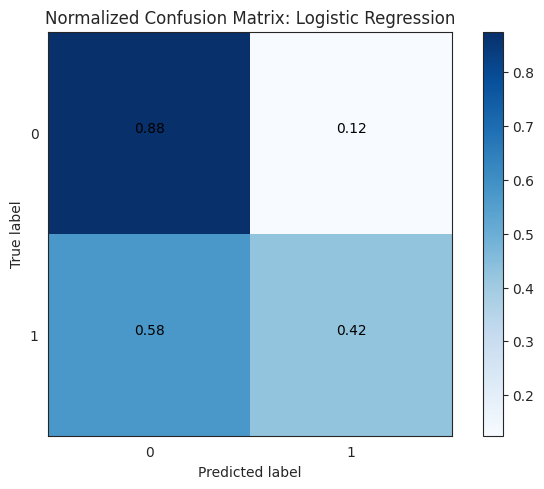

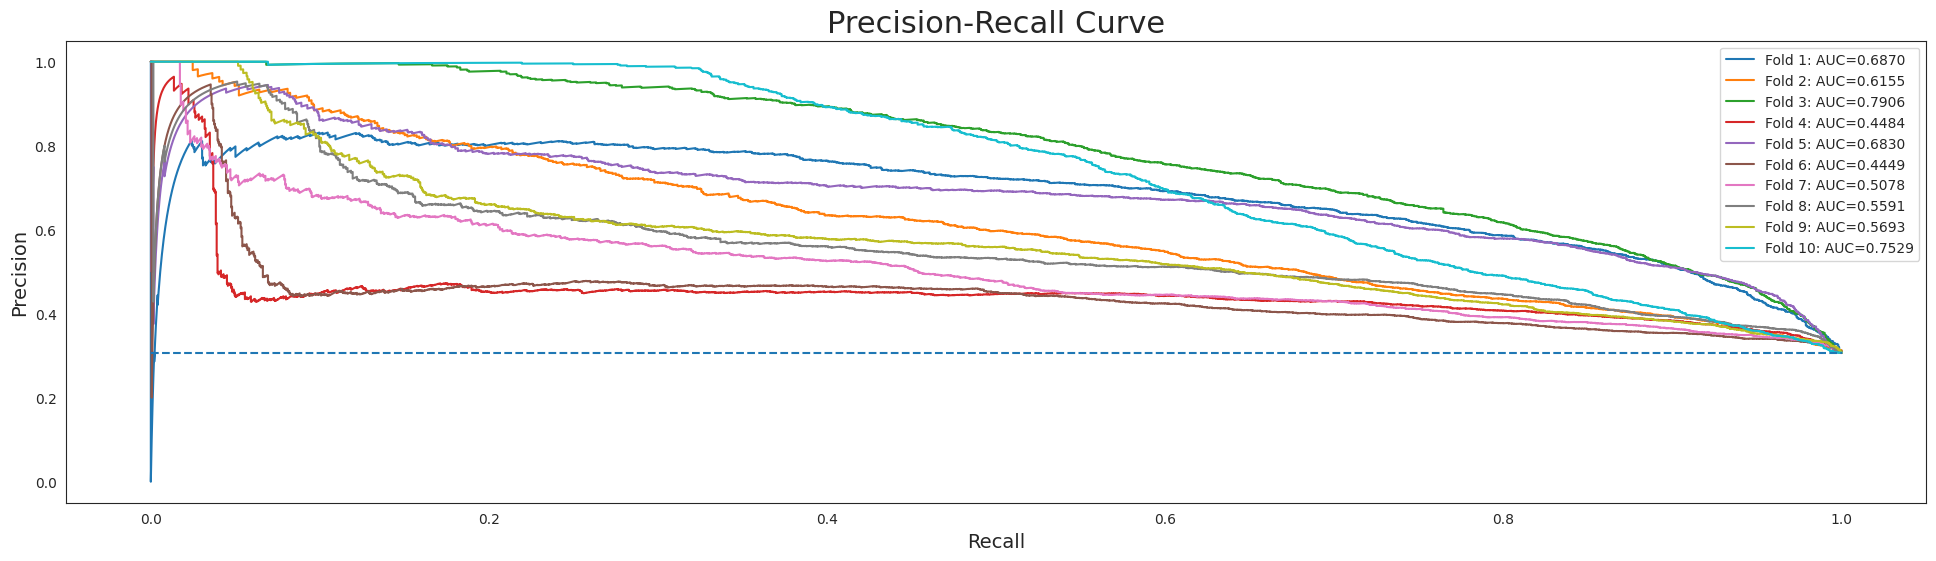

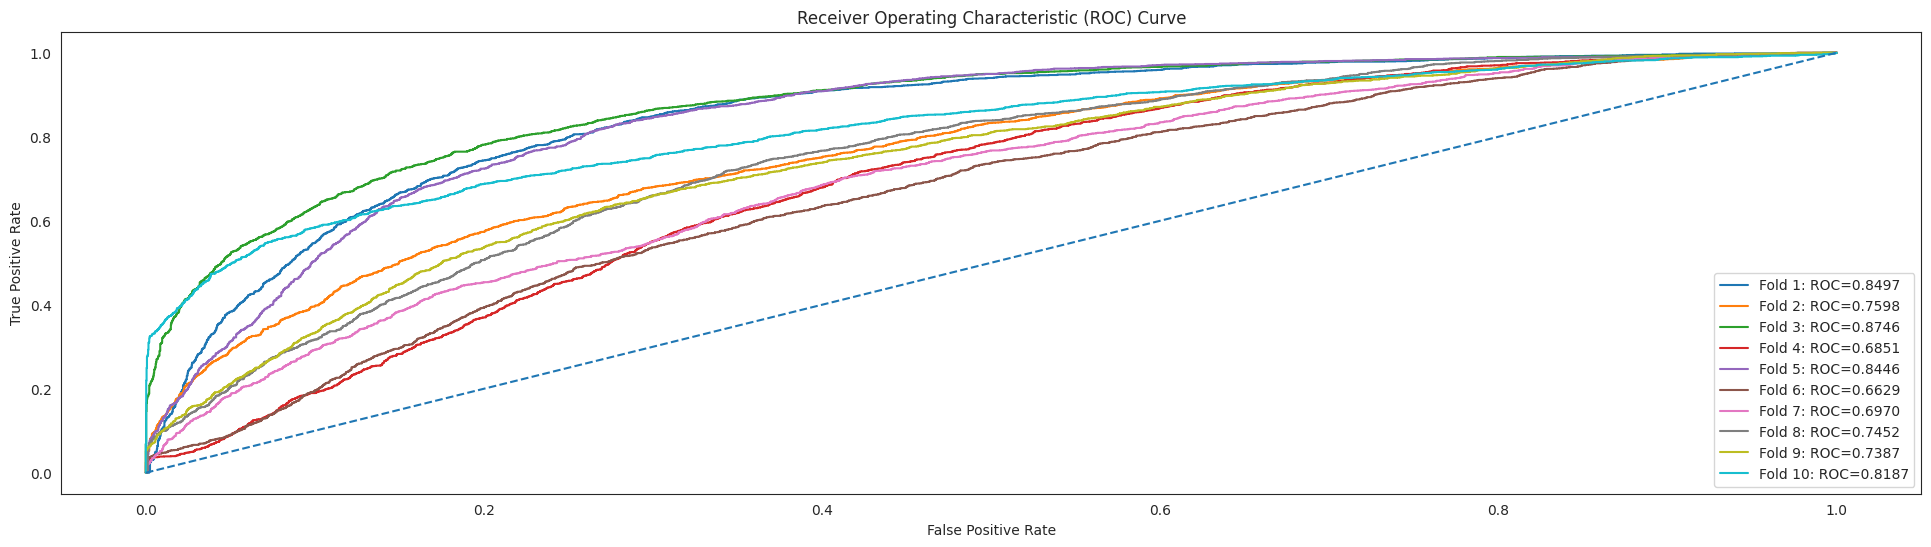

                     0            1  accuracy    macro avg  weighted avg
precision     0.776313     0.606621  0.736473     0.691467      0.724165
recall        0.875090     0.424022  0.736473     0.649556      0.736473
f1-score      0.821135     0.490430  0.736473     0.655782      0.719506
support    4456.900000  1977.400000  0.736473  6434.300000   6434.300000


In [ ]:
X = np.array(sin_only_df.drop("is_canceled", axis=1))
y = np.array(sin_only_df["is_canceled"])

run_test(X, y)

##Cos only

        0      1
0  3884.3  572.6
1  1142.1  835.3
[[0.87152505 0.12847495]
 [0.57757662 0.42242338]]


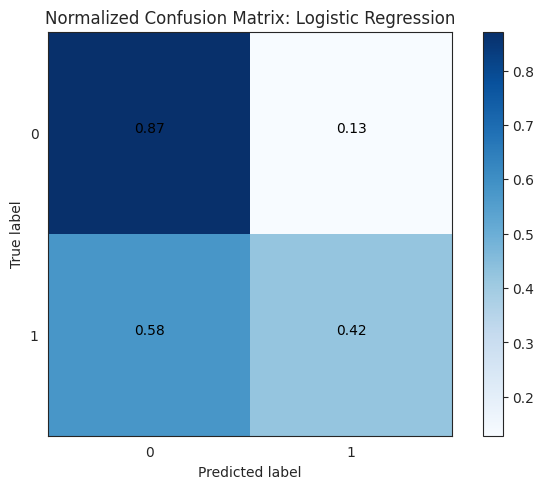

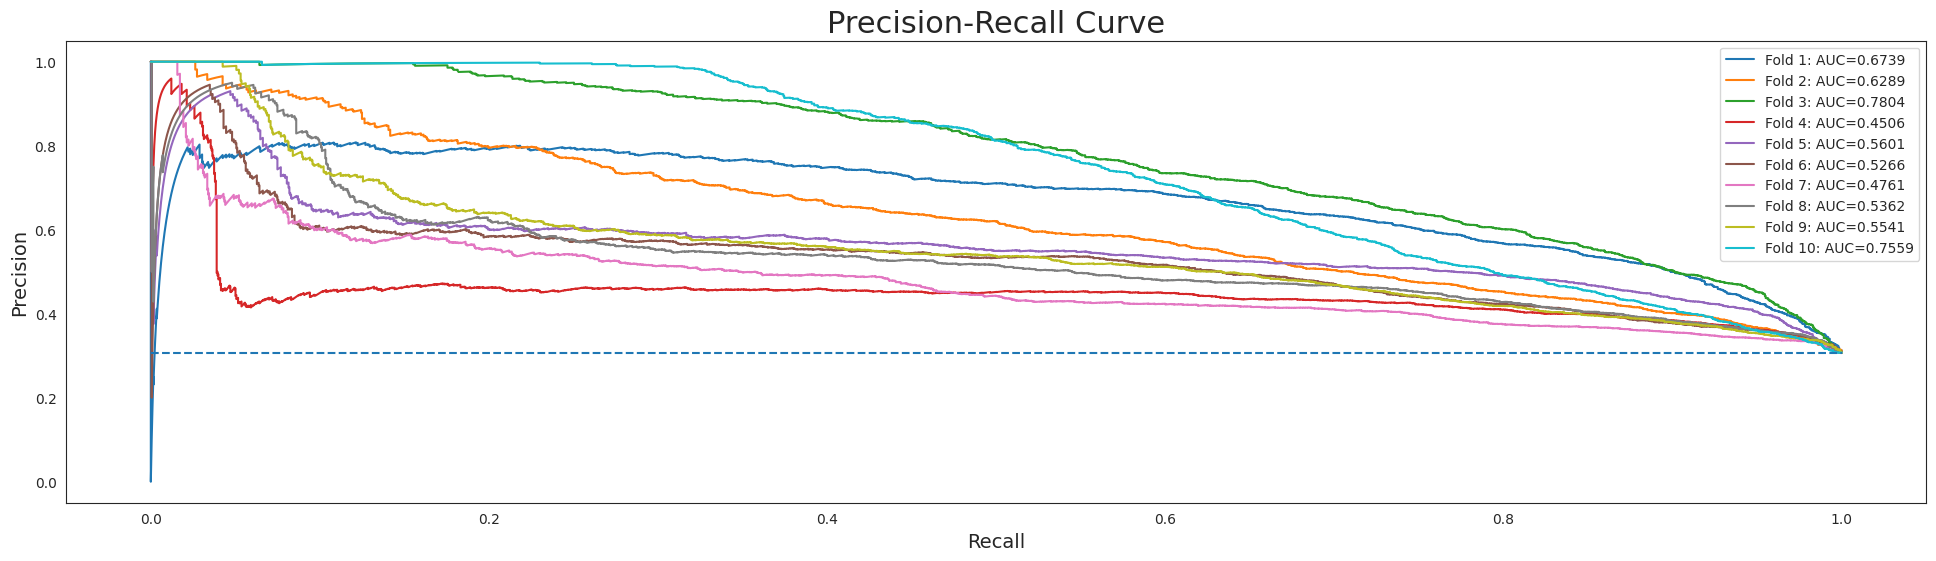

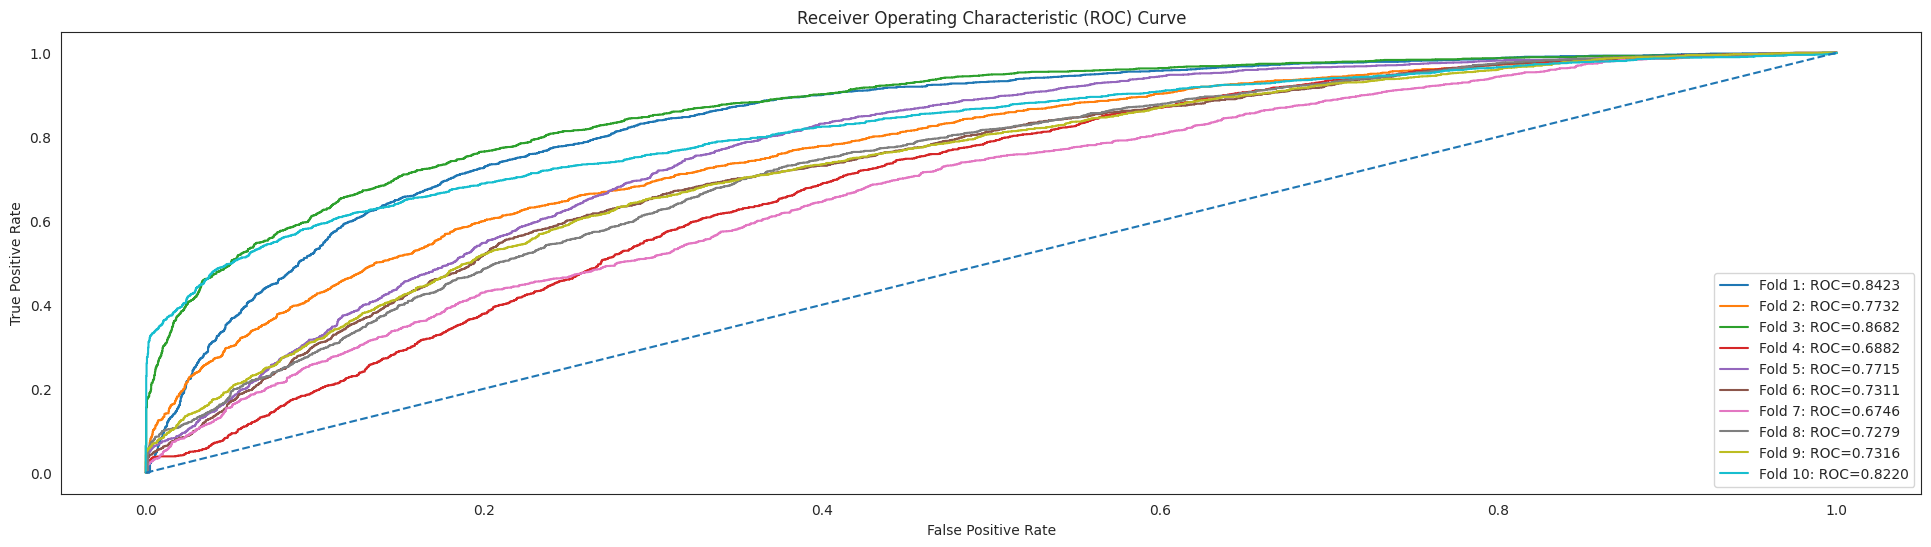

                     0            1  accuracy    macro avg  weighted avg
precision     0.775192     0.598120  0.733504     0.686656      0.720776
recall        0.871523     0.422403  0.733504     0.646963      0.733504
f1-score      0.818907     0.485472  0.733504     0.652190      0.716439
support    4456.900000  1977.400000  0.733504  6434.300000   6434.300000


In [ ]:
X = np.array(cos_only_df.drop("is_canceled", axis=1))
y = np.array(cos_only_df["is_canceled"])

run_test(X, y)

#To CSV

In [ ]:
cos_only_df.to_csv('./3cleaned_cyclical.csv', index=False)

#OHE Run

        0       1
0  3901.7   555.2
1   410.3  1567.1
[[0.87542911 0.12457089]
 [0.20749469 0.79250531]]


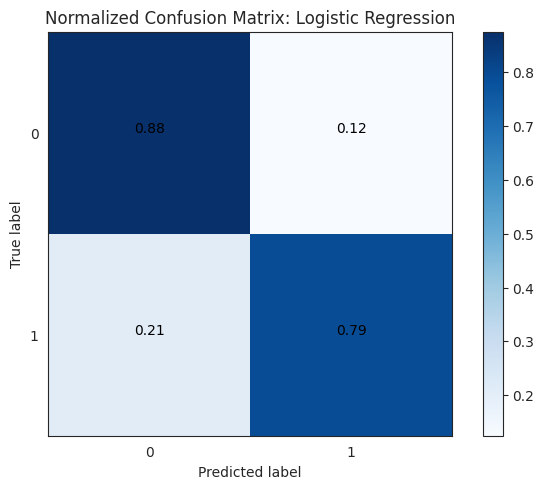

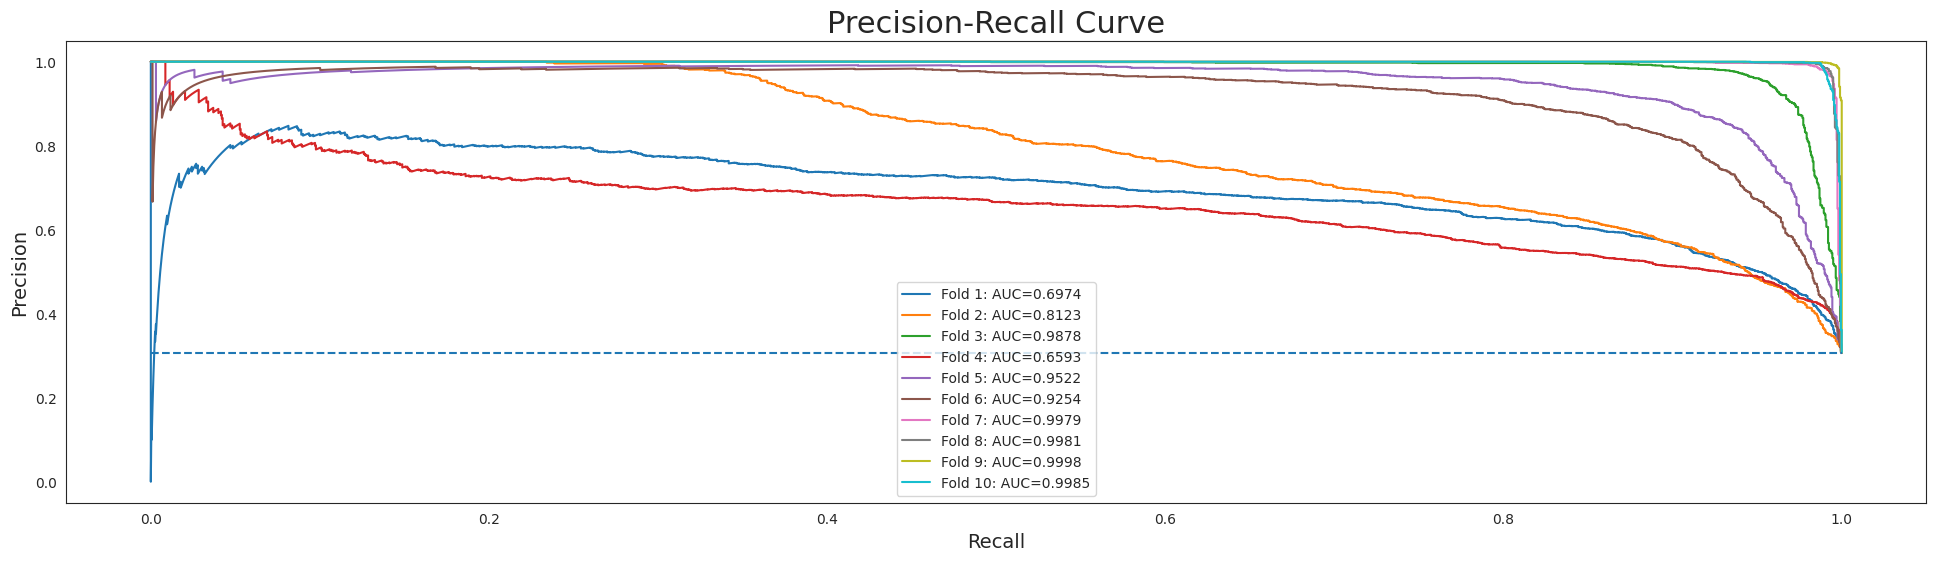

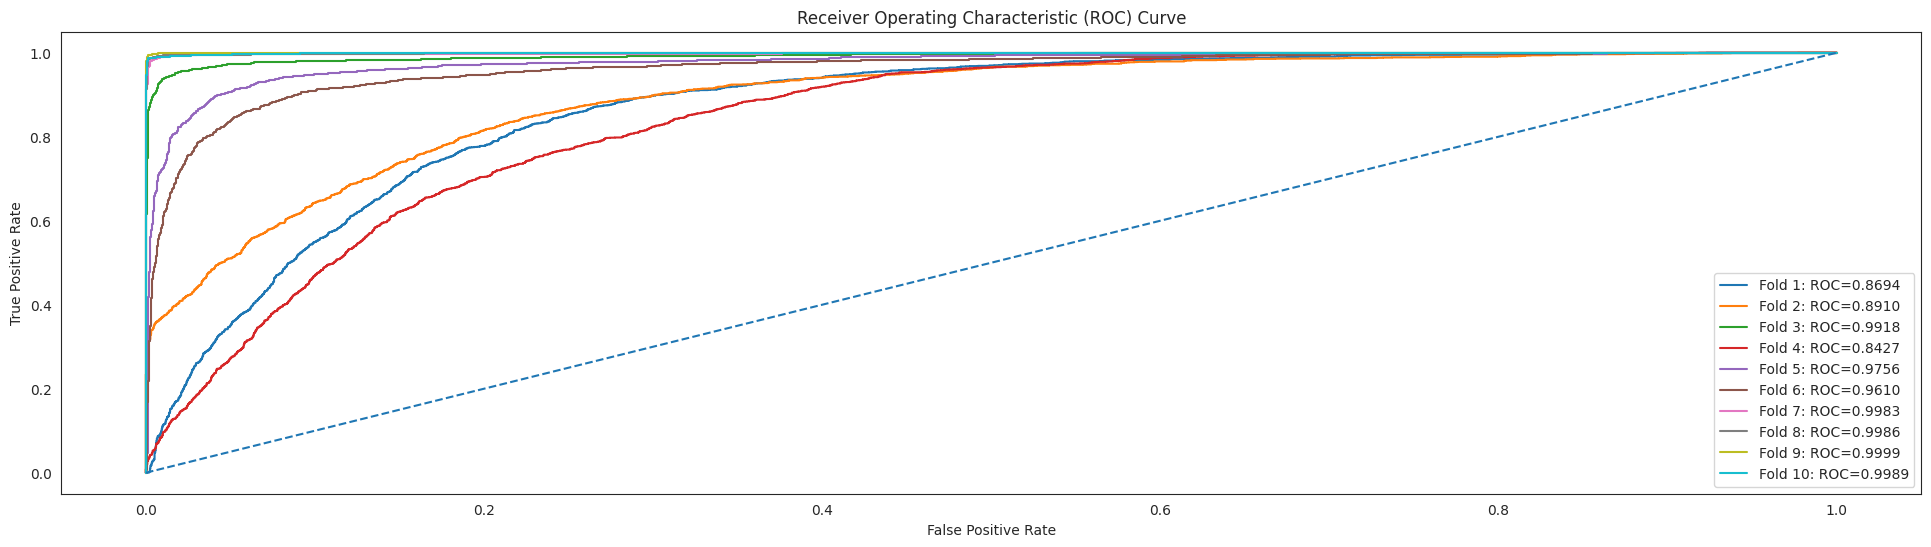

                     0            1  accuracy    macro avg  weighted avg
precision     0.916594     0.844800  0.849946     0.880697      0.894534
recall        0.875432     0.792531  0.849946     0.833981      0.849946
f1-score      0.872690     0.781068  0.849946     0.826879      0.844529
support    4456.900000  1977.400000  0.849946  6434.300000   6434.300000


In [ ]:
ohe = pd.read_csv('https://drive.google.com/uc?export=download&id=1lfIYfDe0YV5b_o3umVAew-FBSmtNZ4R3')

X = np.array(ohe.drop("is_canceled", axis=1))
y = np.array(ohe["is_canceled"])

run_test(X, y)